In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('M1_final.csv')

print(df.isnull().sum()) #How many nulls in each feature? There are 0 so no need for further action

print("Features/Columns:")
print(df.columns)
print("\n")

print("First 5 rows:")
print(df.head(5))

features_to_drop = ['TAIL_NUM', 'DEST','OP_UNIQUE_CARRIER'] #drop the features that are unimportant for the model. Following the procedure of previous research
df = df.drop(columns=features_to_drop)


df['IS_DELAY'] = (df['DEP_DELAY'] >= 15).astype(int) #create a binary target feature to indicate whether a flight is delayed. If a flight departs >=15min late, then it is considered to be delayed

le_wind = LabelEncoder() #encode the categorical variables
le_condition = LabelEncoder()

df['Wind'] = le_wind.fit_transform(df['Wind'])
df['Condition'] = le_condition.fit_transform(df['Condition'])

print("Wind unique values:", le_wind.classes_)
print("Wind encoded values:", list(range(len(le_wind.classes_))))
print("\nCondition unique values:", le_condition.classes_)
print("Condition encoded values:", list(range(len(le_condition.classes_))))

print("Data types of all columns:")
print(df.dtypes)

df['Dew Point'] = df['Dew Point'].astype(int) #oddity in the dataset, must convert this into an int

print("Data types of all columns:") #ensure that the conversion was successful
print(df.dtypes)




MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
TAIL_NUM             0
DEST                 0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
CRS_DEP_M            0
DEP_TIME_M           0
CRS_ARR_M            0
Temperature          0
Dew Point            0
Humidity             0
Wind                 2
Wind Speed           0
Wind Gust            0
Pressure             0
Condition            0
sch_dep              0
sch_arr              0
TAXI_OUT             0
dtype: int64
Features/Columns:
Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'DEST', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M',
       'DEP_TIME_M', 'CRS_ARR_M', 'Temperature', 'Dew Point', 'Humidity',
       'Wind', 'Wind Speed', 'Wind Gust', 'Pressure', 'Condition', 'sch_dep',
       'sch_arr', 'TAXI_OUT'],
      dtype='object')


First 5 rows:
   MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER TAIL_NUM DES

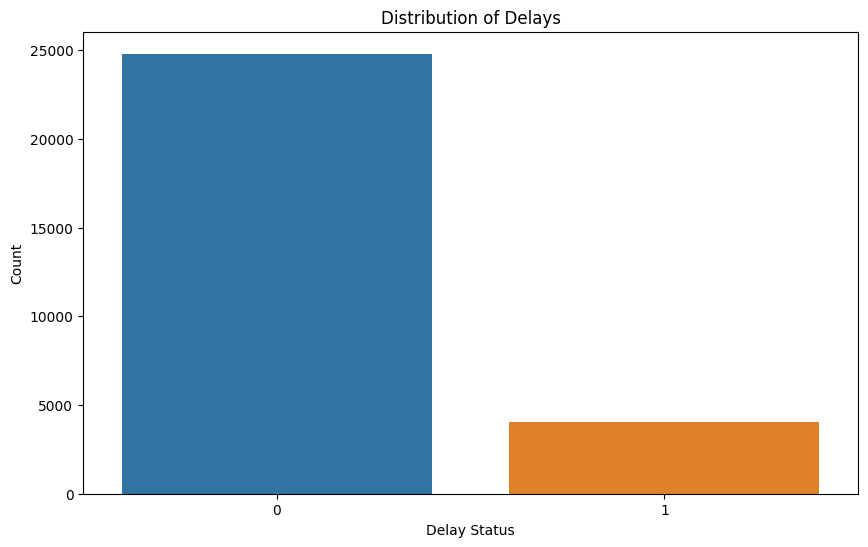

In [ ]:
plt.figure(figsize=(10, 6)) #plot the distribution of delays to confirm the need for a class imbalance solution
sns.countplot(data=df, x='IS_DELAY')
plt.title('Distribution of Delays')
plt.xlabel('Delay Status')
plt.ylabel('Count')
plt.show()

This confirms that when utilizing the dataset, there is a strong need for a class imbalance solution.

In [ ]:
df.describe() #get the basic statistic values for each feature

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,...,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT,IS_DELAY
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,...,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,7.894240,16.021096,4.008952,6.374983,225.288203,1267.746079,831.003851,828.934698,910.874289,41.489833,...,57.732616,9.577793,12.367627,5.535323,30.092433,10.371131,31.091256,28.432130,20.858570,0.139521
std,4.991723,8.750179,1.985230,38.735144,119.482417,889.343246,299.398525,305.864103,345.411743,8.043533,...,23.468676,5.101199,6.259298,11.886457,0.296160,7.273523,9.510359,8.263043,6.851915,0.346496
min,1.000000,1.000000,1.000000,-22.000000,57.000000,94.000000,301.000000,1.000000,1.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,29.200000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,1.000000,8.000000,2.000000,-6.000000,124.000000,483.000000,545.000000,542.000000,667.000000,36.000000,...,46.000000,6.000000,8.000000,0.000000,29.880000,3.000000,26.000000,21.000000,16.000000,0.000000
50%,11.000000,16.000000,4.000000,-3.000000,188.000000,1029.000000,856.000000,854.000000,918.000000,42.000000,...,59.000000,9.000000,12.000000,0.000000,30.110000,16.000000,30.000000,30.000000,19.000000,0.000000
75%,12.000000,24.000000,6.000000,2.000000,365.000000,2248.000000,1095.000000,1097.000000,1193.000000,47.000000,...,74.000000,15.000000,16.000000,0.000000,30.320000,16.000000,37.000000,35.000000,25.000000,0.000000
max,12.000000,31.000000,7.000000,1276.000000,697.000000,4983.000000,1439.000000,1440.000000,1439.000000,68.000000,...,97.000000,18.000000,36.000000,49.000000,30.750000,24.000000,55.000000,46.000000,41.000000,1.000000


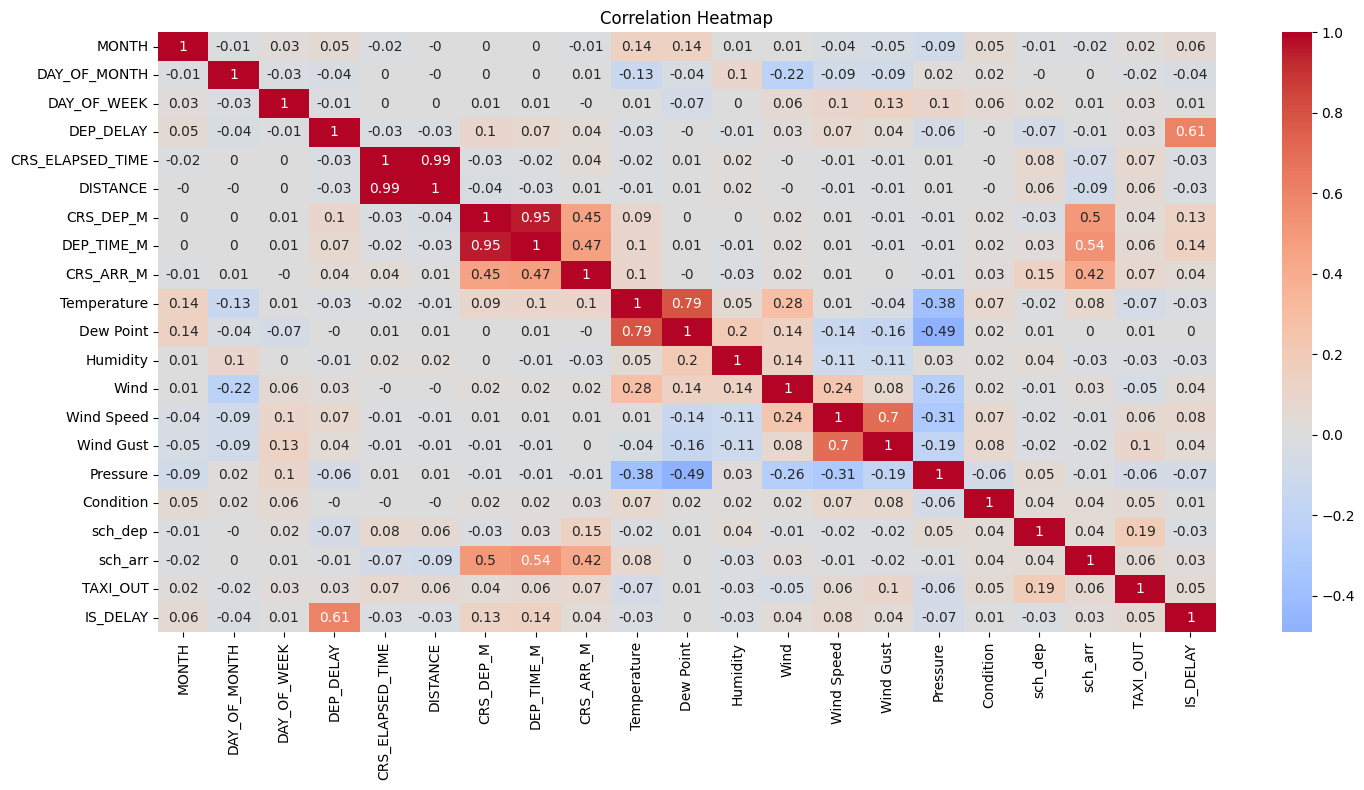

In [ ]:
plt.figure(figsize=(15, 8)) #heatmap
correlation = df.corr().round(2)
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
X = df.drop(['IS_DELAY', 'DEP_DELAY'], axis=1) #drop the target variable, as well as the variable that the target is derived from

y = df['IS_DELAY']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42) #create the models, n_estimators are the default value.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}
 
for name, model in models.items(): #train al models
    model.fit(X_train, y_train)

In [ ]:
#If the user wants to use Cross Validation, the metrics of each fold are printed and the average of each metrics across each fold is calculated and printed

#If the user does not want to use Cross Validation, the metrics and simply found using the imported functions
def evaluate(models, X_train, y_train, crossVal=True, folds=10): 
    def get_detailed_cv_scores(model, X, y, n_splits=10, random_state=42):

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        fold_metrics = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model.fit(X_fold_train, y_fold_train)
            
            y_pred = model.predict(X_fold_val)
            
            metrics = {
                'fold': fold,
                'accuracy': accuracy_score(y_fold_val, y_pred),
                'precision': precision_score(y_fold_val, y_pred, average='weighted'),
                'recall': recall_score(y_fold_val, y_pred,average='weighted'),
                'f1': f1_score(y_fold_val, y_pred,average='weighted')
            }
            
            fold_metrics.append(metrics)
        
        metrics_df = pd.DataFrame(fold_metrics)
        
        metrics_summary = pd.DataFrame({
            'mean': metrics_df.mean(),
            'std': metrics_df.std()
        }).round(3)
        
        return metrics_df, metrics_summary
    
    for name, model in models.items():
        if crossVal:
            print(f"\n{name} Results:")
            print("-" * 50)
            
            fold_results, summary = get_detailed_cv_scores(model, X_train, y_train, n_splits=folds)
            
            print("\nMetrics for each fold:")
            print(fold_results.round(3).to_string(index=False))
            
            print("\nSummary statistics:")
            print(summary.drop('fold', errors='ignore'))
            print("\n")
        else:
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
    
            weighted_precision = precision_score(y_test, y_pred, average='weighted')
            weighted_recall = recall_score(y_test, y_pred, average='weighted')
            weighted_f1 = f1_score(y_test, y_pred, average='weighted')
            
            print(f'\n{name} Results:')
            print(f'Accuracy: {accuracy:.4f}')
            print('\nWeighted Metrics:')
            print(f'Weighted Precision: {weighted_precision:.4f}')
            print(f'Weighted Recall: {weighted_recall:.4f}')
            print(f'Weighted F1-score: {weighted_f1:.4f}')



In [ ]:
evaluate(models, X_train, y_train)

Will now try models with:

SMOTE
SMOTE + 5-fold CV
SMOTE + 10-fold CV
Random Undersampling (RUS)
RUS + 10-fold CV
Custom Class Weights (CCW)
CCW + 10-fold CV

10-fold CV was chosen for RUS and CCW because SMOTE + 10-fold CV performed better than SMOTE + 5-fold CV


In [ ]:
#Now to utilize just SMOTE

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

models_SMOTE = { #reset models
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models_SMOTE.items():
    model.fit(X_train_SMOTE, y_train_SMOTE)

evaluate(models_SMOTE, X_train_SMOTE, y_train_SMOTE, crossVal=False)
print("=============================================================")



Decision Tree Results:
Accuracy: 0.9577

Weighted Metrics:
Weighted Precision: 0.9573
Weighted Recall: 0.9577
Weighted F1-score: 0.9574

Random Forest Results:
Accuracy: 0.9094

Weighted Metrics:
Weighted Precision: 0.9042
Weighted Recall: 0.9094
Weighted F1-score: 0.8973

Gradient Boosting Results:
Accuracy: 0.8917

Weighted Metrics:
Weighted Precision: 0.8836
Weighted Recall: 0.8917
Weighted F1-score: 0.8863


In [ ]:
evaluate(models, X_train_SMOTE, y_train_SMOTE, crossVal=True) #SMOTE + 10-fold cross-validataion



Decision Tree Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.973      0.973   0.973 0.973
    2     0.976      0.976   0.976 0.976
    3     0.970      0.970   0.970 0.970
    4     0.980      0.980   0.980 0.980
    5     0.979      0.979   0.979 0.979
    6     0.976      0.976   0.976 0.976
    7     0.976      0.976   0.976 0.976
    8     0.974      0.974   0.974 0.974
    9     0.974      0.974   0.974 0.974
   10     0.974      0.974   0.974 0.974

Summary statistics:
            mean    std
accuracy   0.975  0.003
precision  0.975  0.003
recall     0.975  0.003
f1         0.975  0.003



Random Forest Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.959      0.960   0.959 0.959
    2     0.961      0.963   0.961 0.961
    3     0.957      0.958   0.957 0.957
    4     0.962      0.963   0.962 0.962
   

In [ ]:
evaluate(models, X_train_SMOTE, y_train_SMOTE, crossVal=True, folds=5) #SMOTE + 5-fold cross-validation



Decision Tree Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.975      0.975   0.975 0.975
    2     0.975      0.975   0.975 0.975
    3     0.967      0.967   0.967 0.967
    4     0.970      0.970   0.970 0.970
    5     0.969      0.969   0.969 0.969

Summary statistics:
            mean    std
accuracy   0.971  0.004
precision  0.971  0.004
recall     0.971  0.004
f1         0.971  0.004



Random Forest Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.959      0.960   0.959 0.959
    2     0.958      0.959   0.958 0.958
    3     0.954      0.956   0.954 0.954
    4     0.955      0.955   0.955 0.954
    5     0.958      0.959   0.958 0.958

Summary statistics:
            mean    std
accuracy   0.957  0.002
precision  0.958  0.002
recall     0.957  0.002
f1         0.957  0.002



Gradient Boosting Resul

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Random undersampling with no cross-validation

rus = RandomUnderSampler(random_state=42)
X_train_RUS, y_train_RUS = rus.fit_resample(X_train, y_train)

models_rus = {#reset models
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models_rus.items():
    model.fit(X_train_RUS, y_train_RUS)

print("Results with Random Undersampling:")
evaluate(models_rus, X_train_RUS, y_train_RUS, crossVal=False)
print("=============================================================")



Results with Random Undersampling:

Decision Tree Results:
Accuracy: 0.9400

Weighted Metrics:
Weighted Precision: 0.9498
Weighted Recall: 0.9400
Weighted F1-score: 0.9428

Random Forest Results:
Accuracy: 0.8286

Weighted Metrics:
Weighted Precision: 0.8863
Weighted Recall: 0.8286
Weighted F1-score: 0.8469

Gradient Boosting Results:
Accuracy: 0.9041

Weighted Metrics:
Weighted Precision: 0.9198
Weighted Recall: 0.9041
Weighted F1-score: 0.9094


In [ ]:
#Random Undersampling with cross-validation
print("Results with Random Undersampling and CV:")
evaluate(models_rus, X_train_RUS, y_train_RUS, crossVal=True)


Results with Random Undersampling and CV:

Decision Tree Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.911      0.911   0.911 0.911
    2     0.939      0.940   0.939 0.939
    3     0.910      0.910   0.910 0.910
    4     0.903      0.903   0.903 0.903
    5     0.941      0.941   0.941 0.941
    6     0.955      0.955   0.955 0.955
    7     0.955      0.955   0.955 0.955
    8     0.961      0.961   0.961 0.961
    9     0.931      0.932   0.931 0.931
   10     0.928      0.928   0.928 0.928

Summary statistics:
            mean   std
accuracy   0.933  0.02
precision  0.934  0.02
recall     0.933  0.02
f1         0.933  0.02



Random Forest Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.827      0.827   0.827 0.827
    2     0.802      0.804   0.802 0.802
    3     0.854      0.854   0.854 0.854
    4  

In [ ]:
#custom class weights without cross-validation

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}

models_weighted = { #reset models
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight=weight_dict),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight=weight_dict),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42) 
}

sample_weights = np.ones(len(y_train))
sample_weights[y_train == 1] = class_weights[1]
sample_weights[y_train == 0] = class_weights[0]

for name, model in models_weighted.items():
    if name == 'Gradient Boosting': #This model has different methods for using custom weights
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

print("\nResults with Class Weights:")
evaluate(models_weighted, X_train, y_train, crossVal=False)
print("=============================================================")



Results with Class Weights:

Decision Tree Results:
Accuracy: 0.9846

Weighted Metrics:
Weighted Precision: 0.9844
Weighted Recall: 0.9846
Weighted F1-score: 0.9844

Random Forest Results:
Accuracy: 0.9138

Weighted Metrics:
Weighted Precision: 0.9170
Weighted Recall: 0.9138
Weighted F1-score: 0.8986

Gradient Boosting Results:
Accuracy: 0.9308

Weighted Metrics:
Weighted Precision: 0.9360
Weighted Recall: 0.9308
Weighted F1-score: 0.9327


In [ ]:
#custom class weights with cross-validation
print("\nResults with Class Weights and CV:")
evaluate(models_weighted, X_train, y_train, crossVal=True)


Results with Class Weights and CV:

Decision Tree Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.982      0.982   0.982 0.982
    2     0.983      0.983   0.983 0.983
    3     0.972      0.972   0.972 0.972
    4     0.983      0.983   0.983 0.983
    5     0.978      0.978   0.978 0.978
    6     0.983      0.983   0.983 0.983
    7     0.983      0.983   0.983 0.983
    8     0.983      0.983   0.983 0.983
    9     0.976      0.976   0.976 0.976
   10     0.978      0.978   0.978 0.978

Summary statistics:
           mean    std
accuracy   0.98  0.004
precision  0.98  0.004
recall     0.98  0.004
f1         0.98  0.004



Random Forest Results:
--------------------------------------------------

Metrics for each fold:
 fold  accuracy  precision  recall    f1
    1     0.908      0.909   0.908 0.891
    2     0.911      0.911   0.911 0.896
    3     0.907      0.912   0.907 0.889
    4     0.9